### Домашнее задание 2

Выполнил Козин Роман

Для начала отберём 10 классов для работы с ними

In [1]:
import random
random.seed(52)
CLASS_NUM = 10
classes_path = './data/tiny-imagenet-200/tiny-imagenet-200/wnids.txt'
with open(classes_path) as f:
    ids = f.read().split('\n')
print(ids)

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', 'n02165456'

Возьмём случайные десять классов, в исходном текстовом файле была пустая строка, учтём это при отборе случайных классов

In [2]:
selected_classes = random.sample(ids[:-1], CLASS_NUM)
print(selected_classes)

['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']


Вот наши классы, чтобы случайно не потерять их, выпишем их в список явно

In [3]:
selected_classes = ['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']

## Часть 1: Подготовка данных

Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

* Метод ```__init__```: инициализация путей к данным, загрузка списка изображений и меток
* Метод ```__len__```: возврат количества примеров в датасете
* Метод ```__getitem__```: загрузка и возврат одного примера (изображение + метка)

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch
import os
class SmallDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, device: str = "cpu", transform = None) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        if ds_type == 'val':
            self.prepareValData()
        self.device = torch.device(device)
        self.transform = transform
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def __getitem__(self, index: int):
        if self.ds_type == 'val':
            data = self.valData[index]
            img_path = os.path.join(self.root, self.ds_type, "images", data[0])
            label = data[1]
            bbox = tuple(data[2:])
        else:
            label_idx = index // 500
            img_idx = index % 500
            label = self.classes[label_idx]
            label_root = os.path.join(self.root, self.ds_type, label)
            img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
            with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                rows = f.readlines()
                f.close()
            row = rows[img_idx]
            data = self._parseLine(row)
            bbox = tuple(data[1:])
            
        img = Image.open(img_path)
            
        if self.transform:
            img = self.transform(img)
        return (img, label, bbox)
        
    def __len__(self) -> int:
        #структура исходного датасета такова, что на каждый класс приходится 500 изображений
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

Создайте базовый residual блок со следующей структурой:

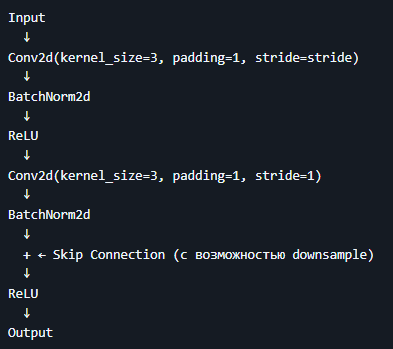

Важно:

* Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
* Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [19]:
import torch.nn as nn

class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.relu(res)
        return res

In [ ]:
x = torch.randn(1, 3, 64, 64)

model = BasicResBlock(3, 16, stride=2)
print(model(x).shape)

torch.Size([1, 16, 64, 64])
